# Práctica 4: Redes neuronales convolucionales para clasificación de imágenes

En esta práctica, vamos a utilizar modelos profundos para clasificar dígitos manuscritos, de forma similar al práctico 1. En este caso, utilizaremos el dataset MNIST donde los dígitos poseen un tamaño de 28x28 (en lugar de 8x8 como en dicho práctico). 

Para eso, comenzamos por cargar y visualizar el dataset:

c:\Users\mauri\Desktop\Facultad\Tesis\Pasantia\.venv\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


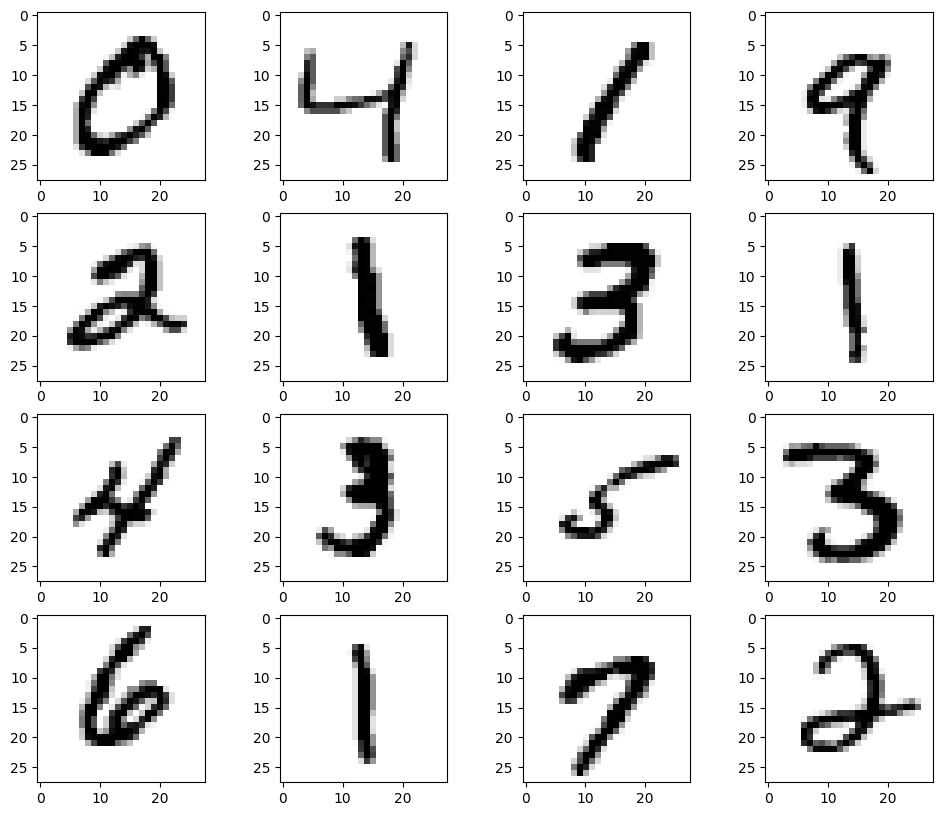

In [1]:
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0, loss = 0.333075
Epoch 1, loss = 0.119298
Epoch 2, loss = 0.141398
Epoch 3, loss = 0.0360288
Epoch 4, loss = 0.0472149
Epoch 5, loss = 0.0237778
Epoch 6, loss = 0.0368886
Epoch 7, loss = 0.0347615
Epoch 8, loss = 0.160639
Epoch 9, loss = 0.0524396
Epoch 10, loss = 0.0133761
Epoch 11, loss = 0.0173322
Epoch 12, loss = 0.100916
Epoch 13, loss = 0.0743223
Epoch 14, loss = 0.0198582
Epoch 15, loss = 0.00974821
Epoch 16, loss = 0.00468293
Epoch 17, loss = 0.00847069
Epoch 18, loss = 0.0521716
Epoch 19, loss = 0.0234584
Epoch 20, loss = 0.0432183
Epoch 21, loss = 0.0706099
Epoch 22, loss = 0.000732276
Epoch 23, loss = 0.04695
Epoch 24, loss = 0.00918116
Epoch 25, loss = 0.0189898
Epoch 26, loss = 0.00171609
Epoch 27, loss = 0.00497089
Epoch 28, loss = 0.0136769
Epoch 29, loss = 0.0527758
Epoch 30, loss = 0.00670411
Epoch 31, loss = 0.00197595
Epoch 32, loss = 0.00113967
Epoch 33, loss = 0.00130362
Epoch 34, loss = 0.00220254
Epoch 35, loss = 0.0342568
Epoch 36, loss = 0.000433452
Epo

Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

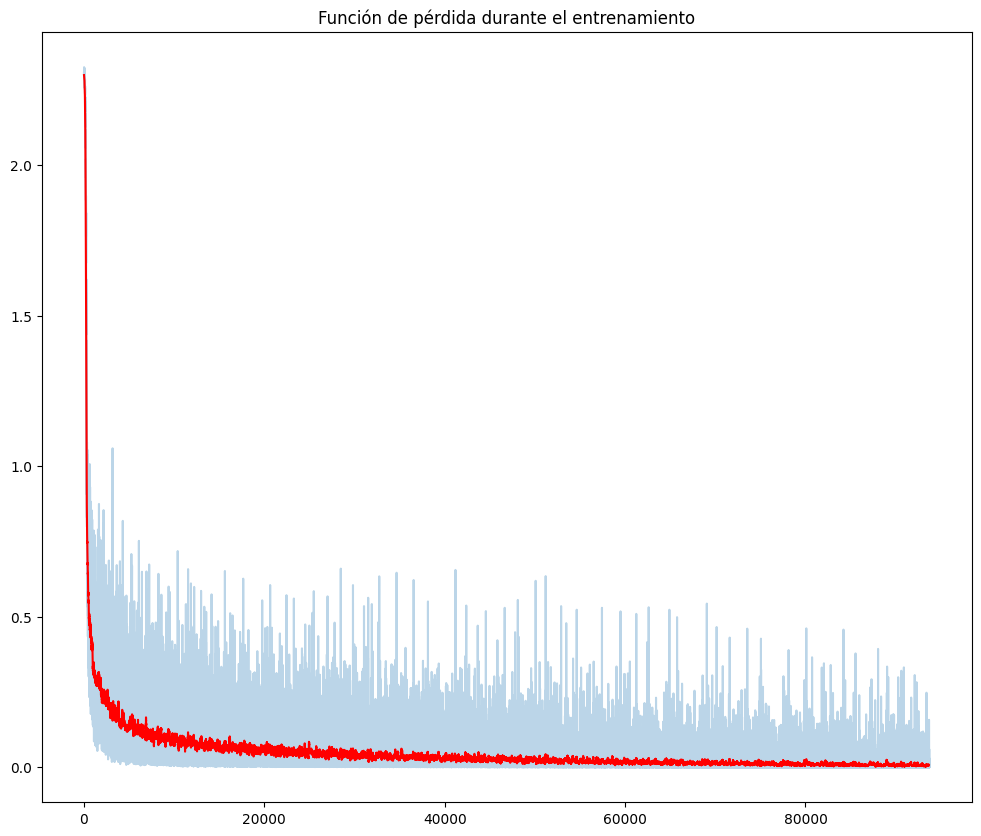

In [3]:
# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss() 

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 50

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")

### Guardo el modelo

In [4]:
torch.save(net.state_dict(), "./models/cnn20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [6]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./models/cnn20.pth"))
net.to(device)

C:\Users\mauri\AppData\Local\Temp\ipykernel_25880\3799096794.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("./models/cnn20.pth"))


NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



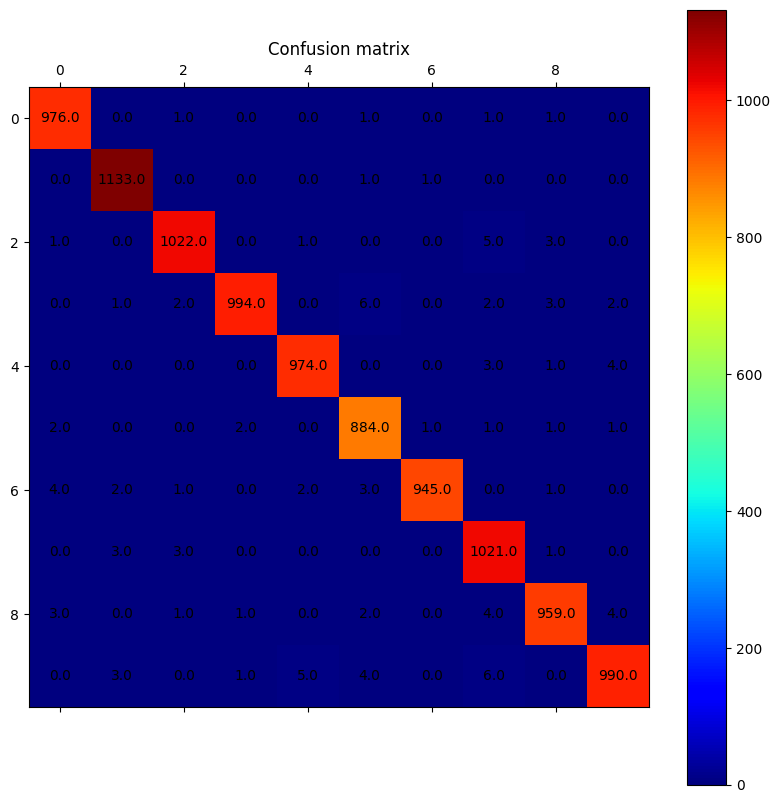

In [7]:
def showTestResults(model):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Genero un data loader para leer los datos de test 
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Muevo los tensores a la GPU
  x_test = x_test.to(device)

  # Realizo las predicciones del modelo
  pred = model(x_test)

  # Extraigo el índice de la predicción con mayor valor para decidir la clase asignada
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Imprimo el reporte de clasificación (accuracy, etc)
  print(classification_report(y_test, pred_y))

  # Computo la matriz de confusión y la muestro
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
      
  plt.title("Confusion matrix")
  plt.colorbar()

showTestResults(net)